In [1]:
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":20})
rc("text", usetex=True)

In [3]:
from nuclearpy_models.models.rc import sr_rc, mnp_rc

In [4]:
exp_df = pd.read_csv('../../Data/Experimental/rc.csv', delimiter=',').query("Z>12").drop_duplicates(subset=['Z', 'N']).query("Z<=50")
exp_df["A"] = exp_df["Z"] + exp_df["N"]

In [5]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames

used_dfs = [
    # "DD-ME2",
    "SKMS",
    "NL3S",
    "UNEDF1",
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in th_datastes if th_dataste in used_dfs]
# th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("(N+Z)<250") for th_dataste in th_datastes}
th_w_target_df = {th_dataste: thdfs[th_dataste].rename(columns={"ChRad": "Rav"} ) for th_dataste in th_datastes if "ChRad" in thdfs[th_dataste].columns and "AME2020" not in th_dataste}

In [6]:
th_w_target_df = {th_dataste: thdfs[th_dataste].rename(columns={"ChRad": "Rav"} ) for th_dataste in th_datastes}

In [7]:
train_df = pd.read_csv('../../Data/Experimental/rc_train.csv', delimiter=',').query("Z>=12").drop_duplicates(subset=['Z', 'N'])
test_df = pd.read_csv('../../Data/Experimental/rc_test.csv', delimiter=',').query("Z>=12").drop_duplicates(subset=['Z', 'N'])
exp_df["is_train"] = [np.nan]*len(exp_df)
for Z, N in zip(test_df["Z"], test_df["N"]):
    try:
        exp_df["is_train"][(exp_df["Z"]==Z) & (exp_df["N"]==N)] = False
    except:
        print(Z, N)
for Z, N in zip(train_df["Z"], train_df["N"]):
    try:
        exp_df["is_train"][(exp_df["Z"]==Z) & (exp_df["N"]==N)] = True
    except:
        print(Z, N)

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_79306/373354907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df["is_train"][(exp_df["Z"]==Z) & (exp_df["N"]==N)] = False


In [8]:
for key, th_dset in th_w_target_df.items():
    exp_df[key] = [np.nan] * len(exp_df)


In [9]:
%%capture
for key, th_dset in th_w_target_df.items():
    missing = 0
    for Z, N in zip(th_dset["Z"], th_dset["N"]):
        try:
            exp_df[key].loc[(exp_df["Z"]==Z) & (exp_df["N"]==N)] = th_dset["Rav"].loc[(th_dset["Z"]==Z) & (th_dset["N"]==N)].values[0]
        except:
            missing+=1
    print(f"{key} missing {missing} values")

In [10]:
sr_rc(20, 20)

(3.4651572076925703, 0.01561231724449641)

In [11]:
def plot_range_no_ref(Z, n_min, n_max, sq = True, index=-1,
                      save_path=None, add_label="",
                      avoid_th=False,
                      ):
    fig, ax = plt.subplots(figsize=(8, 6))
    n = np.arange(n_min, n_max+1)
    if not sq:
        plt.errorbar(exp_df.query(f"Z=={Z}")["N"], exp_df.query(f"Z=={Z}")["Rav"], yerr=exp_df.query(f"Z=={Z}")["delta_Rav"], fmt='o', label="exp", color="black")
        sns.lineplot(x=exp_df.query(f"Z=={Z}")["N"], y=exp_df.query(f"Z=={Z}")["Rav"], color="black")
        if not avoid_th:
            for key, th_dset in th_w_target_df.items():
                foo_df = exp_df.query(f"Z=={Z}").query(f"N>={n_min} and N<={n_max}")[["Z",
                    "N", key]].dropna()
                plt.scatter(foo_df["N"], foo_df[key], label=key, s=10)
                plt.plot(foo_df["N"], foo_df[key], ls="--", alpha=0.5)

        preds_sr = [sr_rc(Z, n, index=index) for n in n]
        unc = [pred[1] for pred in preds_sr]
        preds_sr = [pred[0] for pred in preds_sr]
        preds_mnp = [mnp_rc(Z, n) for n in n]
        plt.plot(n, preds_mnp, color="grey", alpha=0.5)
        plt.scatter(n, preds_mnp,  label="Nerlo-Pomorska",color="grey", s=10)
        plt.plot(n, preds_sr, color="blue")
        plt.scatter(n, preds_sr, color="blue", label="MISR$^{(1)}$")
        plt.fill_between(n, np.array(preds_sr)-np.array(unc), np.array(preds_sr)+np.array(unc), color="blue", alpha=0.1)
        plt.xlabel("N")
        plt.ylabel(r"$\langle r_{\rm av}\rangle$ [fm]")
        plt.legend(loc="lower right")
    else:
        n = np.arange(n_min, n_max+1)
        sns.lineplot(x=exp_df.query(f"Z=={Z}")["N"], y=exp_df.query(f"Z=={Z}")["Rav"]**2, color="black")
        delta_r_unc = exp_df.query(f"Z=={Z}")["delta_Rav"]**2 + 2*exp_df.query(f"Z=={Z}")["Rav"]*exp_df.query(f"Z=={Z}")["delta_Rav"]
        plt.errorbar(exp_df.query(f"Z=={Z}")["N"], exp_df.query(f"Z=={Z}")["Rav"]**2, yerr=delta_r_unc, fmt='s', label="Experiment", color="black")
        if not avoid_th:
            for key, th_dset in th_w_target_df.items():
                foo_df = exp_df.query(f"Z=={Z}").query(f"N>={n_min} and N<={n_max}")[["Z",
                    "N", key]].dropna()
                deltas = (foo_df[key]**2)
                plt.scatter(foo_df["N"], deltas, label=key, s=10)
                plt.plot(foo_df["N"],deltas, ls="--", alpha=0.6)
        preds_mnp = [mnp_rc(Z, n) for n in n]
        deltas_mnp = (np.array(preds_mnp)**2)
        plt.plot(n, deltas_mnp, color="grey", alpha=0.6, ls="--")
        plt.scatter(n, deltas_mnp,  label="NP",color="grey", s=10)
        preds_sr = [sr_rc(Z, n, index=index) for n in n]
        unc = [pred[1] for pred in preds_sr]
        preds_sr = [pred[0] for pred in preds_sr]
        deltas_sr = (np.array(preds_sr)**2 )
        unc_delta_sr = (np.array(unc)**2 + 2*np.array(preds_sr)*np.array(unc))
        plt.plot(n, deltas_sr, color="blue")
        plt.scatter(n, deltas_sr, color="blue", label="MISR$^{(10)}$")
        plt.fill_between(n, deltas_sr-unc_delta_sr, deltas_sr+unc_delta_sr, color="blue", alpha=0.1)
        plt.xlabel("N")
        plt.ylabel(r"$\langle r_{\rm av}^2\rangle$ [fm$^2$]")
        plt.legend(loc="upper left", ncols=2)
    if add_label:
        fig.add_artist(plt.Text(0.5, 0.2, add_label, fontsize=25))
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')


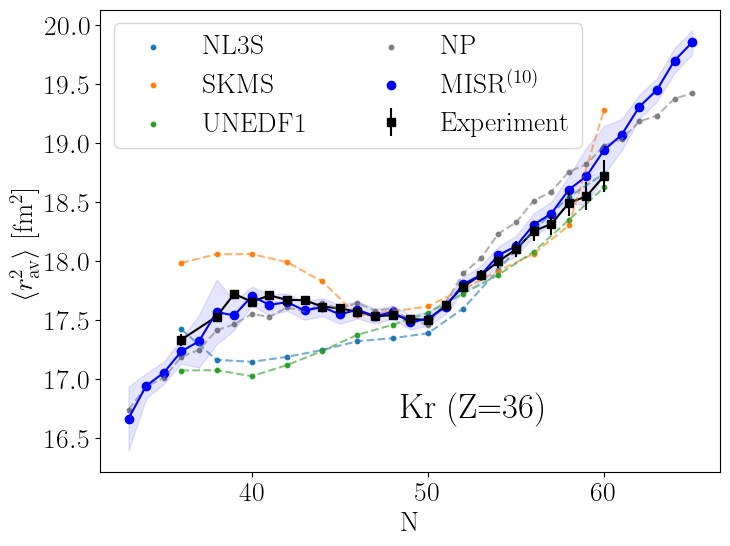

In [12]:
plot_range_no_ref(Z=36, n_min=33, n_max=65, sq=True, index=-1, save_path="./plots/range_z_36.pdf", add_label="Kr (Z=$36$)")

In [27]:
def plot_range_multiple_predictions(exp_df, Zs: list, n_min, n_max, legends: list, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = sns.color_palette("tab10", len(Zs))
    for i, Z in enumerate(Zs):
        ref_z = sr_rc(Z, 28, index=-1)
        predsr = [sr_rc(Z, n) for n in range(n_min, n_max+1)]
        preds = [pred[0]**2 for pred in predsr]
        unc = [2*pred[0]*pred[1] for pred in predsr]
        plt.scatter(range(n_min, n_max+1), preds, color=colors[Zs.index(Z)], marker="o")
        plt.text(27+i, (ref_z[0]**2)+0.1+0.15*i, legends[i] + f" (Z={Z})", fontsize=18, color=colors[Zs.index(Z)], rotation=20)
        plt.plot(range(n_min, n_max+1), preds, color=colors[Zs.index(Z)])
        plt.fill_between(range(n_min, n_max+1), np.array(preds)-np.array(unc), np.array(preds)+np.array(unc), alpha=0.3, color=colors[Zs.index(Z)])
        plt.axhline(y=ref_z[0]**2,  linestyle="--", alpha=0.4, color=colors[Zs.index(Z)])
        exp_vals = exp_df.query(f"Z=={Z}").query(f"N>={n_min} and N<={n_max}")[["Z", "N", "Rav"]].dropna()
        exp_uncert = exp_df.query(f"Z=={Z}").query(f"N>={n_min} and N<={n_max}")[["Z", "N", "delta_Rav"]].dropna()

    plt.axvline(x=28, color="b", linestyle="--", alpha=0.2)
    plt.xlabel("N")
    plt.ylabel(r"$\langle r_{\rm av}^2\rangle$ [fm$^2$]")
    plt.xticks(range(n_min, n_max+1))
    plt.legend(loc="upper center", ncols=3)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


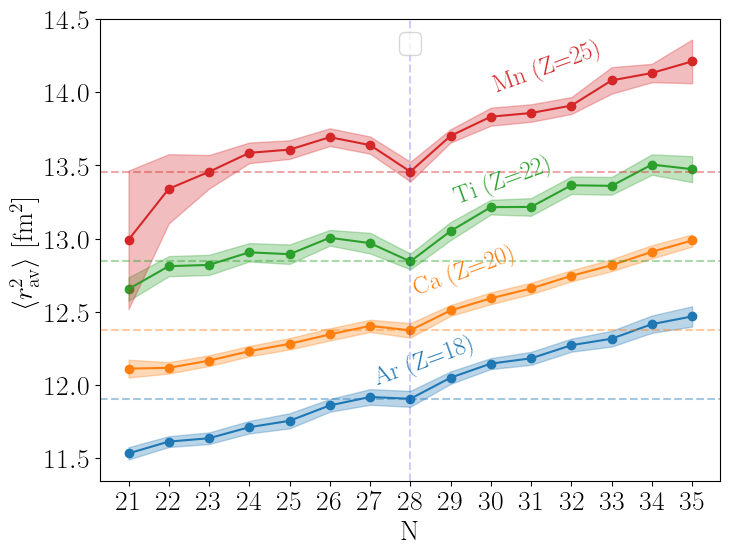

In [28]:
Zs = [18, 20, 22, 25]
names = ["Ar", "Ca", "Ti", "Mn", "Fe"]
plot_range_multiple_predictions(exp_df, Zs, 21, 35, legends=names, save_path="./plots/range_multiple.pdf")

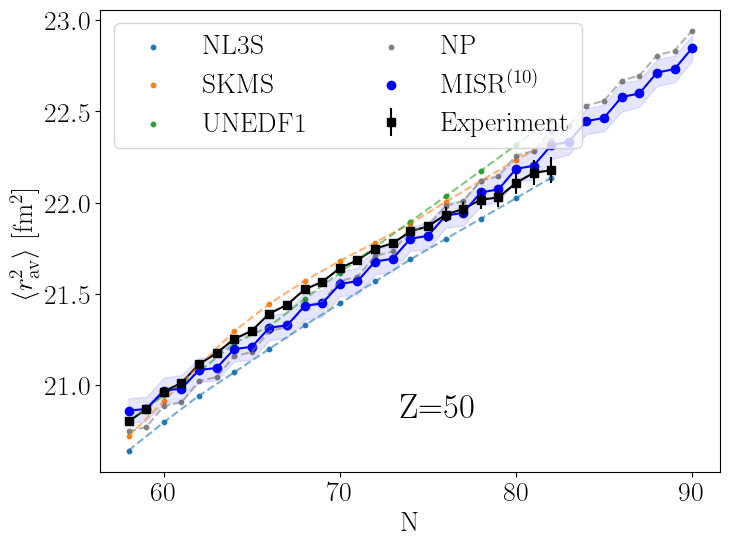

In [29]:
plot_range_no_ref(Z=50, n_min=58, n_max=90, sq=True, index=2, save_path="./plots/range_z_50.png", add_label="Z=$50$")

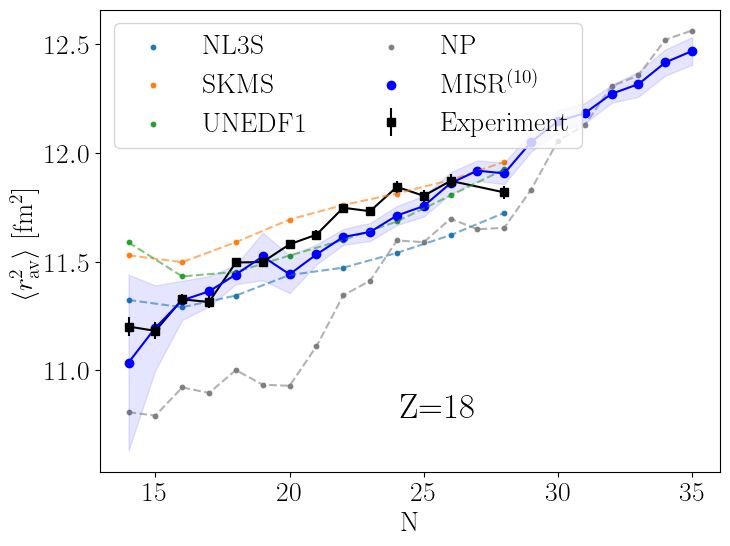

In [30]:
plot_range_no_ref(Z=18, n_min=14, n_max=35, sq=True, index=-1, save_path="./plots/range_z_18.png", add_label="Z=$18$")

In [32]:
if True:
    n_min = 17
    n_max = 34
    Z = 19
    n = np.arange(n_min, n_max+1)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.xlabel("N")
    plt.ylabel(r"$\langle r_{\rm av}\rangle$ [fm]")
    exp_data = exp_df.query(f"Z=={Z}")
    experimental_data = exp_df.query(f"Z=={Z}")["Rav"]
    uncertainty = exp_df.query(f"Z=={Z}")["delta_Rav"]
    plt.errorbar(exp_df.query(f"Z=={Z}")["N"], exp_df.query(f"Z=={Z}")["Rav"], yerr=uncertainty, fmt='o', label="exp", color="black")
    sns.lineplot(x=exp_data["N"], y=exp_data["Rav"], color="black")
    plt.text(0.3, 0.7, f"Z=${Z}$", fontsize=25, transform=ax.transAxes)
    def update(idx):
        ax.clear()
        plt.xlabel("N")
        plt.ylabel(r"$\langle r_{\rm av}\rangle$ [fm]")
        exp_data = exp_df.query(f"Z=={Z}")
        uncertainty = (exp_df.query(f"Z=={Z}")["delta_Rav"])
        plt.errorbar(exp_df.query(f"Z=={Z}")["N"], exp_df.query(f"Z=={Z}")["Rav"], yerr=uncertainty, fmt='s', label="exp", color="black")
        sns.lineplot(x=exp_data["N"], y=exp_data["Rav"], color="black")
        preds_sr = [sr_rc(Z, n_val, index=idx) for n_val in n]
        unc = [pred[1] for pred in preds_sr]
        preds_sr = [pred[0] for pred in preds_sr]
        plt.plot(n, preds_sr, color="blue")
        plt.scatter(n, preds_sr, label=f"MISR$^{{({idx})}}$", color="blue", s=10)
        plt.fill_between(n, np.array(preds_sr)-np.array(unc), np.array(preds_sr)+np.array(unc), color="blue", alpha=0.1)
        ax.plot(n, preds_sr, c=plt.cm.viridis(idx / sr_rc.max_index))
        ax.scatter(n, preds_sr, label=f"MISR$^{{({idx})}}$",
                c=[plt.cm.viridis(idx / sr_rc.max_index)] * len(n), s=10)
        ax.set(ylim=(3.3, 3.55))
        plt.legend(loc="lower right")
        plt.title(f"Predictions for Z=19, Index={idx}")
    anim = FuncAnimation(fig, update, frames=range(0, sr_rc.max_index), repeat=False)
    anim.save(f'./plots/range_z_{Z}.gif', writer='imagemagick',fps=3)
    plt.close(fig)


In [33]:
for key, th_dset in th_w_target_df.items():
    exp_df[f"delta_{key}"] = exp_df.apply(lambda row: np.nan if np.isnan(row[key]) else np.abs(row[key] - row["Rav"]), axis=1)

In [19]:
exp_df["delta_mnp"] = exp_df.apply(lambda row: mnp_rc(row["Z"], row["N"]) - row["Rav"], axis=1)

In [20]:
exp_df["sr_rc"] = exp_df.apply(lambda row: sr_rc(row["Z"], row["N"], -1)[0], axis=1)
train_errors_df = {key: exp_df.query("is_train==True")[f"delta_{key}"].mean() for key, th_dset in th_w_target_df.items()}
exp_df["error_sr"] = exp_df.apply(lambda row: np.abs(row["sr_rc"] - row["Rav"]), axis=1)
train_errors_df["sr_rc"] = np.abs(exp_df[["error_sr", "is_train"]].query("is_train==True")).error_sr.mean()
train_errors_df["mnp_rc"] = np.abs(exp_df[["delta_mnp", "is_train"]].query("is_train==True")).delta_mnp.mean()
test_errors_df = {key: exp_df.query("is_train==False")[f"delta_{key}"].mean() for key, th_dset in th_w_target_df.items()}
exp_df["error_sr"] = exp_df.apply(lambda row: np.abs(row["sr_rc"] - row["Rav"]), axis=1)
test_errors_df["sr_rc"] = np.abs(exp_df[["error_sr", "is_train"]].query("is_train==False")).error_sr.mean()
test_errors_df["mnp_rc"] = np.abs(exp_df[["delta_mnp", "is_train"]].query("is_train==False")).delta_mnp.mean()
train_errors_df = pd.DataFrame(train_errors_df, index=["train"]).T
test_errors_df = pd.DataFrame(test_errors_df, index=["test"]).T
errors_df = train_errors_df
errors_df["test"] = test_errors_df["test"]
errors_df

,train,test
NL3S,0.027756,0.025507
SKMS,0.018543,0.015610
UNEDF1,0.025896,0.019544
sr_rc,0.009346,0.009440
mnp_rc,0.023393,0.017872


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


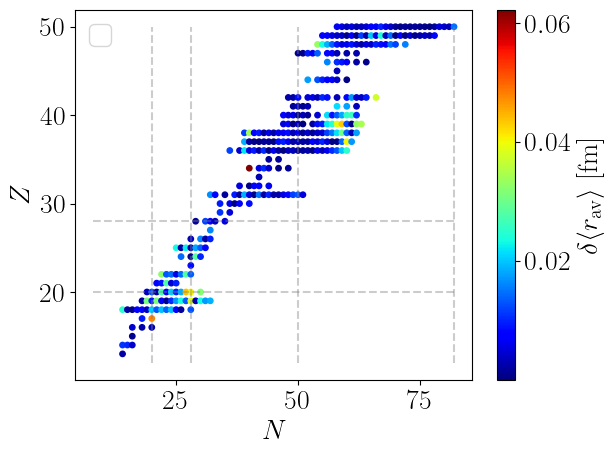

In [21]:
fig, ax = plt.subplots()
g = ax.scatter(exp_df["N"], exp_df["Z"], c=exp_df["error_sr"], cmap="jet", s=15)
plt.colorbar(g, label = r"$\delta\langle r_{\mathrm{av}}\rangle$ [fm]")
n_protons = [20, 28]#, 82, 114]
n_neutrons = [ 20, 28, 50, 82]#, 126, 184]
ax.hlines(n_protons, 8, exp_df["N"].max(), color="grey", linestyle="--", alpha=0.4)
ax.vlines(n_neutrons, 12, exp_df["Z"].max(), color="grey", linestyle="--", alpha=0.4,)
ax.set_xlabel("$N$")
ax.set_ylabel("$Z$", rotation=90)
ax.legend()
plt.savefig("./plots/sr_error_map.pdf", bbox_inches="tight")

In [34]:
def compute_delta_2n(Z, N, model=sr_rc):
    return np.abs(model(Z, N+2, -1)[0] - model(Z, N, -1)[0])

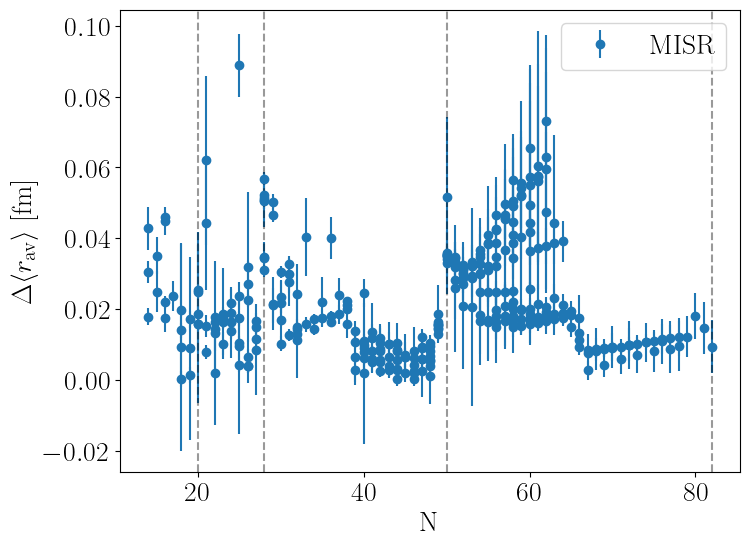

In [42]:
all_deltas = exp_df.apply(lambda row: compute_delta_2n(row["Z"], row["N"]), axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(x=exp_df["N"], y=all_deltas, yerr=exp_df["delta_Rav"], fmt='o', label="MISR")
magic_numbers = [20, 28, 50, 82]
for magic in magic_numbers:
    ax.axvline(magic, color="black", linestyle="--", alpha=0.4)

plt.xlabel("N")
plt.ylabel(r"$\Delta\langle r_{\rm av}\rangle$ [fm]")
plt.legend()
plt.savefig("./plots/delta_2n.pdf", bbox_inches="tight")
